In [4]:
# Install necessary package
!pip install torch-geometric

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt             # Visualization
import seaborn as sns                       # Visualization
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import skew, kurtosis
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Import necessary modules for DL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Set visualization defaults for seaborn
sns.set(color_codes=True)

# Mount Google Drive (if using Google Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    colab_env = True
except ImportError:
    colab_env = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/My Drive/CAMEL_ML_internal/camel_ml_df.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df

,gauge_id,dayl,prcp,srad,swe,tmax,tmin,vp,streamflow,lon_cen,lat_cen
date,,,,,,,,,,,
1980-01-01,1013500,30172.51,0.00,153.40,0,-6.54,-16.30,171.69,655.0,-68.56551,47.01169
1980-01-02,1013500,30253.10,0.00,145.27,0,-6.18,-15.22,185.94,640.0,-68.56551,47.01169
1980-01-03,1013500,30344.18,0.00,146.96,0,-9.89,-18.86,138.39,625.0,-68.56551,47.01169
1980-01-04,1013500,30408.33,0.00,146.20,0,-10.98,-19.76,120.06,620.0,-68.56551,47.01169
1980-01-05,1013500,30413.48,0.00,170.43,0,-11.29,-22.21,117.87,605.0,-68.56551,47.01169
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-27,14400000,32140.81,0.00,196.83,0,9.55,1.93,704.03,3800.0,-124.00527,42.23303
2014-12-28,14400000,32140.81,4.93,133.57,0,7.90,1.59,687.43,3220.0,-124.00527,42.23303
2014-12-29,14400000,32140.81,6.54,134.34,0,5.51,-0.78,581.32,2810.0,-124.00527,42.23303


#GNN

Three train/test procedure. Such as-
1. All gauges (without gauge ID as input): Model is trained on a subset of gauge stations (e.g., 70% of all) together and tested on aother unseen subset of gauge stations. Better to understand the spatial generalization capability.
2. Each site separately: Model trained on each site of a subset of all gauge stations and tested on another subset each site serately.
3. Train/test within sites: Model tarined/tested within each site.    

##All gauges (without gauge id)

In [ ]:
# Get unique gauge_ids
unique_gauge_ids = df['gauge_id'].unique()

# Define the number of samples for each set
num_train = 470
num_dev = 68
num_test = 136

# Randomly sample unique gauge_ids for train, dev, and test sets
train_gauge_ids = np.random.choice(unique_gauge_ids, num_train, replace=False)
remaining_gauge_ids = np.setdiff1d(unique_gauge_ids, train_gauge_ids)
dev_gauge_ids = np.random.choice(remaining_gauge_ids, num_dev, replace=False)
test_gauge_ids = np.setdiff1d(remaining_gauge_ids, dev_gauge_ids)

# Create the subsets
train_df = df[df['gauge_id'].isin(train_gauge_ids)]
dev_df = df[df['gauge_id'].isin(dev_gauge_ids)]
test_df = df[df['gauge_id'].isin(test_gauge_ids)]

# Define features and target
features = ['dayl', 'prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp']
target = ['streamflow']

In [ ]:
# Define a function to train on multiple sites and test on others
def train_on_multiple_sites(train_df, test_df, train_gauge_ids_sample, test_gauge_ids_sample, timesteps=20, epochs=40, batch_size=32):
    # Filter the dataset for the selected training sites
    train_df_sample = train_df[train_df['gauge_id'].isin(train_gauge_ids_sample)]

    # Filter the dataset for the selected testing sites
    test_df_sample = test_df[test_df['gauge_id'].isin(test_gauge_ids_sample)]

    # Initialize the StandardScaler and scale the features
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(train_df_sample[features])
    X_test_scaled = scaler_X.transform(test_df_sample[features])

    # Prepare the target variables
    y_train = train_df_sample[target].values.ravel()
    y_test = test_df_sample[target].values.ravel()

    # Check if there are enough samples for LSTM to work
    if len(X_train_scaled) < timesteps or len(X_test_scaled) < timesteps:
        raise ValueError(f"Not enough samples for LSTM with timesteps={timesteps}.")

    # Define the number of features
    features_count = X_train_scaled.shape[1]

    # Reshape the training data for LSTM
    n_samples_train = X_train_scaled.shape[0]
    n_samples_test = X_test_scaled.shape[0]

    X_train_reshaped = np.zeros((n_samples_train - timesteps + 1, timesteps, features_count))
    X_test_reshaped = np.zeros((n_samples_test - timesteps + 1, timesteps, features_count))

    for i in range(timesteps, n_samples_train + 1):
        X_train_reshaped[i - timesteps] = X_train_scaled[i - timesteps:i]

    for i in range(timesteps, n_samples_test + 1):
        X_test_reshaped[i - timesteps] = X_test_scaled[i - timesteps:i]

    # Reshape the target variables accordingly
    y_train_reshaped = y_train[timesteps-1:]
    y_test_reshaped = y_test[timesteps-1:]

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=64, activation='relu', input_shape=(timesteps, features_count)))
    model.add(Dropout(0.2))
    model.add(Dense(units=32, activation='linear'))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Define early stopping criteria
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

    # Train the LSTM model with early stopping
    history = model.fit(X_train_reshaped, y_train_reshaped,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1,
                        validation_split=0.1,
                        callbacks=[early_stopping])

    # Make predictions on the train set
    y_train_pred = model.predict(X_train_reshaped)
    # Compute R² score for the train set
    r2_train = r2_score(y_train_reshaped, y_train_pred)

    # Make predictions on the test set
    y_test_pred = model.predict(X_test_reshaped)
    # Compute R² score for the test set
    r2_test = r2_score(y_test_reshaped, y_test_pred)

    print(f'Training R² score: {r2_train:.4f}')
    print(f'Testing R² score: {r2_test:.4f}')

    return r2_train, r2_test

# Example usage:
# Manually select sample of gauge stations for training from train_df
train_gauge_ids_sample = train_df['gauge_id'].unique()[:5]  # Manually select 5 gauges for training

# Manually select sample of gauge stations for testing from test_df
test_gauge_ids_sample = test_df['gauge_id'].unique()[:5]  # Manually select 5 gauges for testing

# Run the training and testing process
r2_train, r2_test = train_on_multiple_sites(train_df, test_df, train_gauge_ids_sample, test_gauge_ids_sample)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 55s 13ms/step - loss: 4045802.2500 - val_loss: 681860.6250
Epoch 2/40
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - loss: 3647395.7500 - val_loss: 826684.5625
Epoch 3/40
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 3474842.7500 - val_loss: 461090.5625
Epoch 4/40
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 3399564.2500 - val_loss: 1168321.1250
Epoch 5/40
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 3136986.0000 - val_loss: 1406886.8750
Epoch 6/40
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - loss: 3118502.2500 - val_loss: 972850.4375
Epoch 7/40
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 3042109.0000 - val_loss: 928345.1250
Epoch 8/40
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - loss: 2993253.2500 - val_loss: 1207860.6250
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.
1989/1989 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step
Training R² score:

##Each site separately

In [ ]:
# Get unique gauge_ids
unique_gauge_ids = df['gauge_id'].unique()

# Define the number of samples for each set
num_train = 470
num_dev = 68
num_test = 136

# Randomly sample unique gauge_ids for train, dev, and test sets
train_gauge_ids = np.random.choice(unique_gauge_ids, num_train, replace=False)
remaining_gauge_ids = np.setdiff1d(unique_gauge_ids, train_gauge_ids)
dev_gauge_ids = np.random.choice(remaining_gauge_ids, num_dev, replace=False)
test_gauge_ids = np.setdiff1d(remaining_gauge_ids, dev_gauge_ids)

# Create the subsets
train_df = df[df['gauge_id'].isin(train_gauge_ids)]
dev_df = df[df['gauge_id'].isin(dev_gauge_ids)]
test_df = df[df['gauge_id'].isin(test_gauge_ids)]

# Define features and target
features = ['dayl', 'prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp']
target = ['streamflow']

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Define features and target
features = ['dayl', 'prcp', 'srad', 'tmax', 'tmin', 'vp']
target = ['streamflow']

# Prepare custom dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, features, target, timesteps):
        self.data = data
        self.features = features
        self.target = target
        self.timesteps = timesteps
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()

        # Scale features and target
        self.data[features] = self.scaler_X.fit_transform(self.data[features])
        self.data[target] = self.scaler_y.fit_transform(self.data[target])

        # Generate sliding windows
        self.inputs, self.targets = self._create_windows()

    def _create_windows(self):
        inputs, targets = [], []
        for i in range(len(self.data) - self.timesteps):
            inputs.append(self.data.iloc[i:i + self.timesteps][self.features].values)
            targets.append(self.data.iloc[i + self.timesteps][self.target].values)
        return np.array(inputs), np.array(targets)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.float), torch.tensor(self.targets[idx], dtype=torch.float)

# Prepare training and testing datasets
timesteps = 20
train_data = TimeSeriesDataset(data=train_df, features=features, target=target, timesteps=timesteps)
test_data = TimeSeriesDataset(data=test_df, features=features, target=target, timesteps=timesteps)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Initialize the Model
model = Model(units=64, stack_cnt=2, time_step=timesteps, multi_layer=2, horizon=1, device='cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training Loop
def train_model(model, train_loader, optimizer, criterion, epochs=40):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            forecast, _ = model(X)
            loss = criterion(forecast.squeeze(), y.squeeze())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

# Testing Loop
def test_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X, y in test_loader:
            forecast, _ = model(X)
            predictions.extend(forecast.squeeze().numpy())
            actuals.extend(y.squeeze().numpy())
    return np.array(predictions), np.array(actuals)

# Train the model
train_model(model, train_loader, optimizer, criterion)

# Test the model
predictions, actuals = test_model(model, test_loader)

# Evaluate performance
from sklearn.metrics import r2_score
test_r2 = r2_score(actuals, predictions)
print(f"Test R² Score: {test_r2:.4f}")

<ipython-input-11-b38f7c45b082>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[features] = self.scaler_X.fit_transform(self.data[features])
<ipython-input-11-b38f7c45b082>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[target] = self.scaler_y.fit_transform(self.data[target])


## Train/test within sites

In [ ]:
# Function to calculate NSE and PBIAS
def calculate_nse(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

def calculate_pbias(y_true, y_pred):
    return 100 * np.sum(y_true - y_pred) / np.sum(y_true)

# Function to process a batch of gauge stations and run the GRU model
def process_gauges_individually(df, gauge_ids_batch):
    metrics = []

    for gauge_id in gauge_ids_batch:
        site_data = df[df['gauge_id'] == gauge_id]
        split_index = int(len(site_data) * 0.8)

        train_site_data = site_data.iloc[:split_index]
        test_site_data = site_data.iloc[split_index:]

        scaler_X = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(train_site_data[features])
        X_test_scaled = scaler_X.transform(test_site_data[features])

        y_train = train_site_data[target].values.ravel()
        y_test = test_site_data[target].values.ravel()

        timesteps = 20
        features_count = X_train_scaled.shape[1]

        n_samples_train = X_train_scaled.shape[0]
        n_samples_test = X_test_scaled.shape[0]

        X_train_reshaped = np.zeros((n_samples_train - timesteps + 1, timesteps, features_count))
        X_test_reshaped = np.zeros((n_samples_test - timesteps + 1, timesteps, features_count))

        for i in range(timesteps, n_samples_train + 1):
            X_train_reshaped[i - timesteps] = X_train_scaled[i - timesteps:i]

        for i in range(timesteps, n_samples_test + 1):
            X_test_reshaped[i - timesteps] = X_test_scaled[i - timesteps:i]

        y_train_reshaped = y_train[timesteps-1:]
        y_test_reshaped = y_test[timesteps-1:]

        # Build the Baseline GRU Model
        model = Sequential()
        model.add(GRU(units=32, activation='relu', input_shape=(timesteps, features_count), return_sequences=True))
        model.add(GRU(units=16, activation='relu'))
        model.add(Dense(units=1))  # Output layer

        model.compile(optimizer='adam', loss='mean_squared_error')

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

        model.fit(X_train_reshaped, y_train_reshaped, epochs=40, batch_size=32, verbose=1, validation_split=0.1, callbacks=[early_stopping])

        y_train_pred = model.predict(X_train_reshaped).flatten()
        y_test_pred = model.predict(X_test_reshaped).flatten()

        train_r2 = r2_score(y_train_reshaped, y_train_pred)
        test_r2 = r2_score(y_test_reshaped, y_test_pred)
        train_mse = mean_squared_error(y_train_reshaped, y_train_pred)
        test_mse = mean_squared_error(y_test_reshaped, y_test_pred)
        train_rmse = np.sqrt(train_mse)
        test_rmse = np.sqrt(test_mse)
        train_mae = mean_absolute_error(y_train_reshaped, y_train_pred)
        test_mae = mean_absolute_error(y_test_reshaped, y_test_pred)
        train_nse = calculate_nse(y_train_reshaped, y_train_pred)
        test_nse = calculate_nse(y_test_reshaped, y_test_pred)
        train_pbias = calculate_pbias(y_train_reshaped, y_train_pred)
        test_pbias = calculate_pbias(y_test_reshaped, y_test_pred)

        metrics.append({
            'gauge_id': gauge_id,
            'train_r2': train_r2, 'test_r2': test_r2,
            'train_rmse': train_rmse, 'test_rmse': test_rmse,
            'train_mse': train_mse, 'test_mse': test_mse,
            'train_mae': train_mae, 'test_mae': test_mae,
            'train_nse': train_nse, 'test_nse': test_nse,
            'train_pbias': train_pbias, 'test_pbias': test_pbias
        })

        print(f"Gauge ID: {gauge_id} processed successfully.")

    return pd.DataFrame(metrics)

# Function to process gauge stations in chunks
def process_gauges_in_chunks(df, start_idx=0, chunk_size=30, results_file='results_gru.csv'):
    try:
        results_df = pd.read_csv(results_file)
    except FileNotFoundError:
        results_df = pd.DataFrame(columns=['gauge_id', 'train_r2', 'test_r2', 'train_rmse', 'test_rmse',
                                           'train_mse', 'test_mse', 'train_mae', 'test_mae', 'train_nse',
                                           'test_nse', 'train_pbias', 'test_pbias'])

    unique_gauge_ids = df['gauge_id'].unique()
    total_gauges = len(unique_gauge_ids)

    gauge_ids_batch = unique_gauge_ids[start_idx:start_idx + chunk_size]
    print(f"Processing gauge stations {start_idx + 1} to {min(start_idx + chunk_size, total_gauges)}...")

    df_subset = df[df['gauge_id'].isin(gauge_ids_batch)]
    metrics_df = process_gauges_individually(df_subset, gauge_ids_batch)

    results_df = pd.concat([results_df, metrics_df], ignore_index=True)
    results_df.to_csv(results_file, index=False)

    print("Results saved to", results_file)

# Example usage:
features = ['dayl', 'prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp']
target = ['streamflow']

process_gauges_in_chunks(df, start_idx=0, chunk_size=10)

Processing gauge stations 1 to 10...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 4489927.0000 - val_loss: 1169825.1250
Epoch 2/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 1622387.3750 - val_loss: 752243.0625
Epoch 3/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 1237642.2500 - val_loss: 807503.8125
Epoch 4/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 1167207.0000 - val_loss: 786329.0625
Epoch 5/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1011420.6250 - val_loss: 685664.4375
Epoch 6/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 998295.3125 - val_loss: 581530.8750
Epoch 7/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 919717.4375 - val_loss: 831799.6875
Epoch 8/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 897377.7500 - val_loss: 684392.4375
Epoch 9/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 859929.0000 - val_loss: 892311.3750
Epoch 10/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 898762.8125 - val_loss: 736699.1875
Epoch 11/40
285/285 ━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


285/285 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 398397.6562 - val_loss: 313541.7812
Epoch 2/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 234593.2969 - val_loss: 291612.4375
Epoch 3/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 200682.4375 - val_loss: 235769.8281
Epoch 4/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 184339.0938 - val_loss: 237869.6562
Epoch 5/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 157128.9062 - val_loss: 234085.2344
Epoch 6/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 138158.8438 - val_loss: 201669.0781
Epoch 7/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 138783.3438 - val_loss: 190830.2344
Epoch 8/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 115023.3672 - val_loss: 191964.3594
Epoch 9/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 121452.2266 - val_loss: 162671.7656
Epoch 10/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 126005.8203 - val_loss: 189498.9531
Epoch 11/40
285/285 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


285/285 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 16661119.0000 - val_loss: 13568232.0000
Epoch 2/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 10175263.0000 - val_loss: 9851874.0000
Epoch 3/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 8748255.0000 - val_loss: 11702402.0000
Epoch 4/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 7794516.5000 - val_loss: 7254220.5000
Epoch 5/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 6874086.5000 - val_loss: 7299261.5000
Epoch 6/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 6914847.0000 - val_loss: 6840777.0000
Epoch 7/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 5876147.0000 - val_loss: 7706255.5000
Epoch 8/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 6620863.5000 - val_loss: 7224962.5000
Epoch 9/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 5641214.5000 - val_loss: 6573082.5000
Epoch 10/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 5493298.0000 - val_loss: 7276699.5000
Epoch 11/40
285

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


285/285 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 1453503.6250 - val_loss: 838033.4375
Epoch 2/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 1104256.5000 - val_loss: 695729.0625
Epoch 3/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 821829.0625 - val_loss: 694226.7500
Epoch 4/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 916776.1250 - val_loss: 663333.5000
Epoch 5/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 691965.7500 - val_loss: 726505.6875
Epoch 6/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 826289.3125 - val_loss: 726483.0625
Epoch 7/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 752548.1250 - val_loss: 750730.9375
Epoch 8/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 830816.4375 - val_loss: 655388.0000
Epoch 9/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 955722.5000 - val_loss: 628658.8125
Epoch 10/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 709375.3125 - val_loss: 1277150.8750
Epoch 11/40
285/285 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


288/288 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 2098533.0000 - val_loss: 671796.8750
Epoch 2/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 1547639.0000 - val_loss: 562640.1250
Epoch 3/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 1258680.3750 - val_loss: 601421.2500
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 1187997.7500 - val_loss: 549392.3750
Epoch 5/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 1347977.7500 - val_loss: 570845.5000
Epoch 6/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 1314312.0000 - val_loss: 531288.8750
Epoch 7/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 1332134.2500 - val_loss: 568901.2500
Epoch 8/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 1336436.6250 - val_loss: 524172.4062
Epoch 9/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 1182967.1250 - val_loss: 565244.8750
Epoch 10/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1138127.1250 - val_loss: 659861.5625
Epoch 11/40
288/288 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


288/288 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 365963.8438 - val_loss: 155905.1250
Epoch 2/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - loss: 227322.1875 - val_loss: 180835.8281
Epoch 3/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 226935.2188 - val_loss: 148548.1094
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 217464.9844 - val_loss: 141039.6406
Epoch 5/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 209480.3750 - val_loss: 166658.4531
Epoch 6/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 221624.5625 - val_loss: 165556.3906
Epoch 7/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 178894.6094 - val_loss: 152206.5625
Epoch 8/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 192200.6250 - val_loss: 135805.1406
Epoch 9/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - loss: 180620.5312 - val_loss: 134539.5000
Epoch 10/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 160274.2500 - val_loss: 131003.0703
Epoch 11/40
288/288 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


288/288 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 170843.8750 - val_loss: 56557.0039
Epoch 2/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 149188.6094 - val_loss: 53383.9766
Epoch 3/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 119625.4062 - val_loss: 59714.9648
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 129710.5234 - val_loss: 52044.2344
Epoch 5/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 144357.0469 - val_loss: 50356.0039
Epoch 6/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 124318.8984 - val_loss: 48187.6250
Epoch 7/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 138967.1719 - val_loss: 50170.5312
Epoch 8/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 136254.2344 - val_loss: 50961.6094
Epoch 9/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 124044.8672 - val_loss: 44818.0195
Epoch 10/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 109026.2188 - val_loss: 47644.4258
Epoch 11/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


288/288 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 151996.4844 - val_loss: 138387.5312
Epoch 2/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 130787.8047 - val_loss: 138719.0000
Epoch 3/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 112321.5859 - val_loss: 135084.2656
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 124081.8125 - val_loss: 140891.5156
Epoch 5/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 144605.0156 - val_loss: 147832.0625
Epoch 6/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 111616.6562 - val_loss: 127638.8828
Epoch 7/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 177743.0312 - val_loss: 134757.1250
Epoch 8/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 115416.7812 - val_loss: 135154.2656
Epoch 9/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 101923.5703 - val_loss: 132320.7188
Epoch 10/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 122440.8828 - val_loss: 144271.5156
Epoch 11/40
288/288 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


288/288 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 58687.9844 - val_loss: 15763.2471
Epoch 2/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 36353.9336 - val_loss: 14303.9717
Epoch 3/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 37854.0508 - val_loss: 10233.2988
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 23618.2598 - val_loss: 14142.3271
Epoch 5/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 22968.7344 - val_loss: 7675.5483
Epoch 6/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 18689.2012 - val_loss: 7094.0645
Epoch 7/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 21265.9180 - val_loss: 10740.8877
Epoch 8/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 22162.4531 - val_loss: 8004.5645
Epoch 9/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 17912.8594 - val_loss: 8612.4365
Epoch 10/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 16752.5605 - val_loss: 9392.8447
Epoch 11/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


286/286 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 1046.7919 - val_loss: 485.1419
Epoch 2/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 535.3348 - val_loss: 284.9125
Epoch 3/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 402.4777 - val_loss: 269.5217
Epoch 4/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 323.6222 - val_loss: 233.7080
Epoch 5/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 298.9484 - val_loss: 255.3979
Epoch 6/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 365.5067 - val_loss: 267.5302
Epoch 7/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 257.1791 - val_loss: 229.4806
Epoch 8/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 284.8401 - val_loss: 289.7061
Epoch 9/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 366.5023 - val_loss: 224.2671
Epoch 10/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 217.9742 - val_loss: 217.8315
Epoch 11/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 274.1393 - val_loss: 220.9444
Ep

<ipython-input-3-aa91e2927b1d>:112: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, metrics_df], ignore_index=True)


In [ ]:
results = pd.read_csv('results.csv')
#line plot obs and pred and train test
#Scatterplot

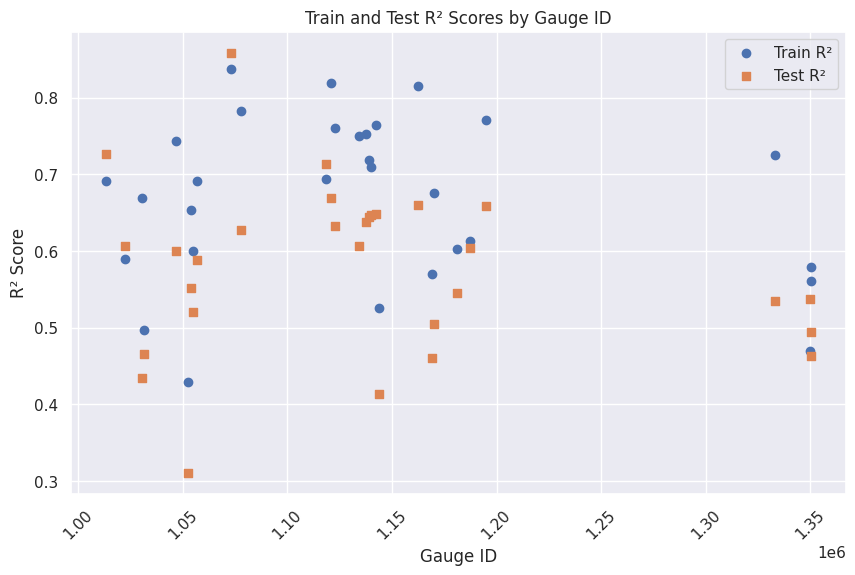

In [ ]:
# Plotting without connecting lines between points
plt.figure(figsize=(10, 6))
plt.scatter(results['gauge_id'], results['train_r2'], label='Train R²', marker='o')
plt.scatter(results['gauge_id'], results['test_r2'], label='Test R²', marker='s')
plt.xlabel('Gauge ID')
plt.ylabel('R² Score')
plt.title('Train and Test R² Scores by Gauge ID')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

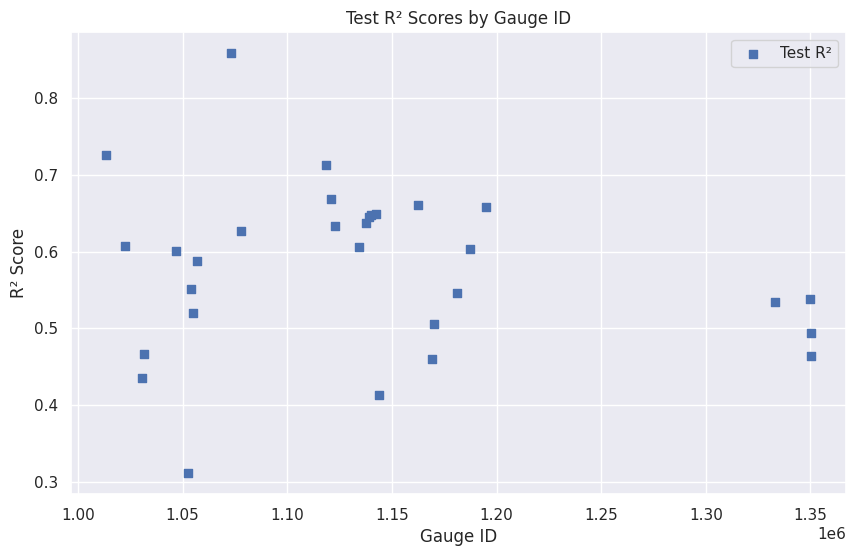

In [ ]:
# Plotting without connecting lines between points
plt.figure(figsize=(10, 6))
plt.scatter(results['gauge_id'], results['test_r2'], label='Test R²', marker='s')
plt.xlabel('Gauge ID')
plt.ylabel('R² Score')
plt.title('Test R² Scores by Gauge ID')
plt.legend()
# plt.xticks(rotation=45)
plt.grid(True)
plt.show()

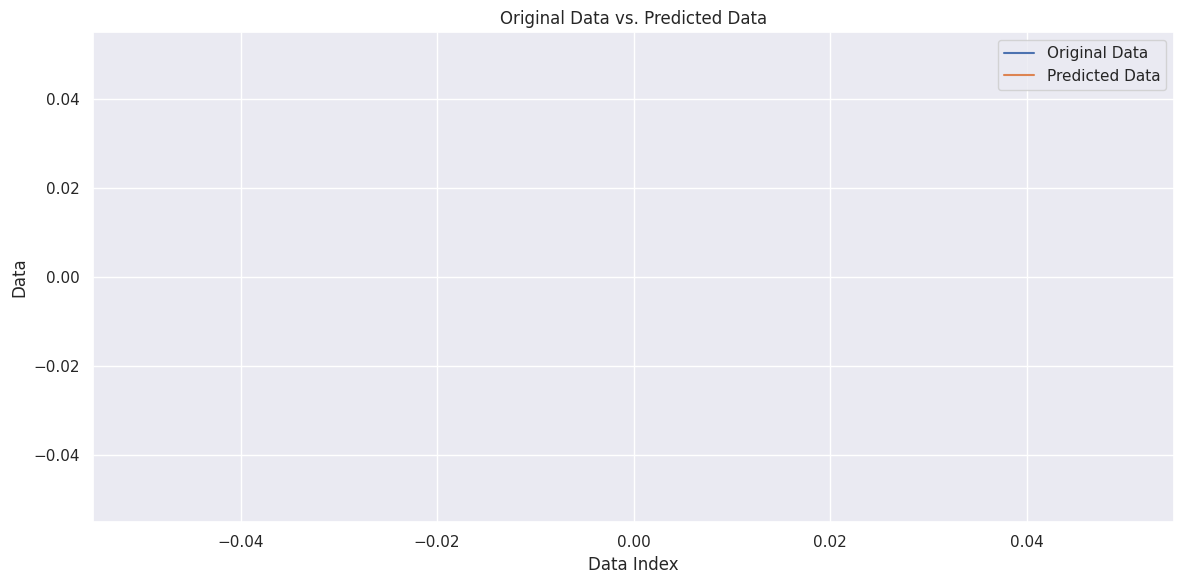

In [ ]:
# Specify the range of rows you want to plot
start_index = 90000
end_index = 110000

# Subset the data within the specified range
subset_df = df_train.iloc[start_index:end_index]

# Plot 'Original Data' and 'Predicted Data' within the specified range
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(subset_df.index, subset_df['Original Data'], label='Original Data')
plt.plot(subset_df.index, subset_df['Predicted Data'], label='Predicted Data')

plt.xlabel('Data Index')
plt.ylabel('Data')
plt.title('Original Data vs. Predicted Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## All gauges (with gauges ids as input)

In [ ]:
# Filter the dataset to include only the first 10 unique gauge_ids
first_10_gauge_ids = df['gauge_id'].unique()[:10]
df_filtered = df[df['gauge_id'].isin(first_10_gauge_ids)]

# Convert gauge_id to categorical for the filtered data
df_filtered['gauge_id'] = df_filtered['gauge_id'].astype('category')

# Split the filtered data into train and test sets based on gauge_id
train_gauge_ids = df_filtered['gauge_id'].unique()[:8]  # First 8 sites for training
test_gauge_ids = df_filtered['gauge_id'].unique()[8:]   # Remaining 2 sites for testing

train_df = df_filtered[df_filtered['gauge_id'].isin(train_gauge_ids)]
test_df = df_filtered[df_filtered['gauge_id'].isin(test_gauge_ids)]

# Define features and target
features = ['dayl', 'prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp']
target = ['streamflow']

# Prepare the X and y datasets for train and test
X_train = train_df[features + ['gauge_id']]
y_train = train_df[target]

X_test = test_df[features + ['gauge_id']]
y_test = test_df[target]

# Get all unique categories in the entire dataset for 'gauge_id'
all_gauge_ids = df_filtered['gauge_id'].unique()

# Define the ColumnTransformer with predefined categories for gauge_id
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features),
        ('cat', OneHotEncoder(categories=[all_gauge_ids], drop='first'), ['gauge_id'])
    ])

# Apply the transformations to the training and test sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Define the number of timesteps and features
timesteps = 20  # Number of previous data points to consider
num_features = X_train_transformed.shape[1]  # Number of features after transformation

# Reshape the training and test data for LSTM
n_samples_train = X_train_transformed.shape[0]
n_samples_test = X_test_transformed.shape[0]

X_train_reshaped = np.zeros((n_samples_train - timesteps + 1, timesteps, num_features))
X_test_reshaped = np.zeros((n_samples_test - timesteps + 1, timesteps, num_features))

for i in range(timesteps, n_samples_train + 1):
    X_train_reshaped[i - timesteps] = X_train_transformed[i - timesteps:i]

for i in range(timesteps, n_samples_test + 1):
    X_test_reshaped[i - timesteps] = X_test_transformed[i - timesteps:i]

# Reshape the target variable accordingly
y_train_reshaped = y_train[timesteps-1:].values.ravel()
y_test_reshaped = y_test[timesteps-1:].values.ravel()

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(timesteps, num_features)))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='linear'))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the LSTM model with early stopping
history = model.fit(X_train_reshaped, y_train_reshaped,
                    epochs=40,
                    batch_size=32,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

# Make predictions on the train set
y_train_pred = model.predict(X_train_reshaped)
# Compute R² score for the train set
r2_train = r2_score(y_train_reshaped, y_train_pred)

# Make predictions on the test set
y_test_pred = model.predict(X_test_reshaped)
# Compute R² score for the test set
r2_test = r2_score(y_test_reshaped, y_test_pred)

print(f'The train R² score is: {r2_train:.4f}')
print(f'The test R² score is: {r2_test:.4f}')

# Pad zeros to match the original time series dimensions for the train data
y_train_pred_padded = np.concatenate((np.zeros(timesteps-1), y_train_pred.flatten()))
# Compute R² score for the padded train data
r2_train_padded = r2_score(y_train, y_train_pred_padded)
print(f'The R² score for the padded train data is: {r2_train_padded:.4f}')

# Pad zeros to match the original time series dimensions for the test data
y_test_pred_padded = np.concatenate((np.zeros(timesteps-1), y_test_pred.flatten()))
# Compute R² score for the padded test data
r2_test_padded = r2_score(y_test, y_test_pred_padded)
print(f'The R² score for the padded test data is: {r2_test_padded:.4f}')